電腦視覺深度學習期末專題  
期末專題主題 : 使用YOLOV3建構浣熊與袋鼠的辨識模型

In [ ]:
%tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.2


In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# 下載基於 keras 的 yolov3 程式碼
%cd 'gdrive/My Drive'
# !git clone https://github.com/qqwweee/keras-yolo3 # 如果之前已經下載過就可以註解掉
%cd DLCVMarathonFinalProject


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive
/content/gdrive/My Drive/DLCVMarathonFinalProject


In [ ]:
!pip install keras==2.2.4 # 需要安裝 keras 2.2.4 的版本

  Using cached https://files.pythonhosted.org/packages/5e/10/aa32dad071ce52b5502266b5c659451cfd6ffcbf14e6c8c4f16c0ff5aaab/Keras-2.2.4-py2.py3-none-any.whl
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
import os

In [ ]:
# 下載資料集
#!git clone https://github.com/experiencor/raccoon_dataset.git
#!git clone https://github.com/experiencor/kangaroo.git

In [ ]:
!ls

 Data   model_data    train_annot.txt	        train.py   yolo.py
 logs   __pycache__  'train_annot.txt 的副本'   yolo3


In [ ]:
# 這一段是只針對期末專題的兩種類別
# 以下直接使用Day41中的function即可

# 先定義目標類別
classes = ['kangaroo', 'raccoon']

# 把 annotation 轉換訓練時需要的資料形態
#def convert_annotation(xml, anno_file, classes):
def convert_annotation(xml, anno_file):
    import xml.etree.ElementTree as ET
    with open(xml, 'r') as f:
      tree = ET.parse(f)
      root = tree.getroot()

      for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult) == 1:
          continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), 
             int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
        anno_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

# 資料夾位置
# Data/kangaroo/images
# Data/raccoon_dataset/images
# Data/kangaroo/annots
# Data/raccoon_dataset/annotations

if not os.path.exists('train_annot.txt'):
  print("train_annot.txt doesn't exists, converting ... ")

  with open('train_annot.txt', 'w') as to_file:
    # 1. 浣熊
    annotationfiles=os.listdir('Data/raccoon_dataset/annotations')
    for annofile in annotationfiles:
      filename = annofile.split('.')[0]
      to_file.write(os.path.join('Data/raccoon_dataset/images', f'{filename}.jpg'))
      convert_annotation(os.path.join('Data/raccoon_dataset/annotations', annofile), to_file)
      to_file.write('\n')

    # 2. 袋鼠
    annotationfiles=os.listdir('Data/kangaroo/annots')
    for annofile in annotationfiles:
      filename = annofile.split('.')[0]
      to_file.write(os.path.join('Data/kangaroo/images', f'{filename}.jpg'))
      convert_annotation(os.path.join('Data/kangaroo/annots', annofile), to_file)
      to_file.write('\n')

  print('train_annot.txt is ready ...')
else:
  print('train_annot.txt exists')

train_annot.txt exists


In [ ]:
#把目別的類別寫入class file
if not os.path.exists('model_data/animal_classes.txt'):
    print('Generating model_data/animal_classes.txt ...')
    
    with open('model_data/animal_classes.txt', 'w') as f:
      for cls in classes:
        f.write(cls)
        f.write('\n')

    print('model_data/animal_classes.txt is ready ...')
else:
    print('model_data/animal_classes.txt exists ...')


model_data/animal_classes.txt exists ...


In [ ]:
# 預訓練權重檔案
if not os.path.exists("model_data/yolo_weights.h5"):
  print("model_data/yolo_weights.h5 does not exist, converting pretrained YOLOv3 weights for training .. ")
  os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
  if not os.path.exists("model_data/yolo_weights.h5"):
    print('Convert Fail ...')
  else:
    print('model_data/yolo_weights.h5 is ready ...')
else:
  print("Pretrained weights exists")

Pretrained weights exists


In [ ]:
# 將所需要的套件載入
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from PIL import ImageFile
from PIL import Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

%matplotlib inline
import matplotlib.pyplot as plt

import cv2
from IPython import display

from yolo import YOLO
from yolo3.model import box_iou
from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

Using TensorFlow backend.


In [ ]:
annotation_path = 'train_annot.txt'
test_dir = 'test/images'
test_annotation = 'test_annot.txt'

log_dir = 'logs/003/'
result_dir = 'results/003'
classes_path = 'model_data/animal_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'

class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416)

In [ ]:
is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val















Create YOLOv3 model with 9 anchors and 2 classes.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_75 due to mismatch in shape ((1,

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train

# 注意：added by chi hsu 20200821
# 在colab中跑到這邊都會出現ValueError: Tensor conversion
# ValueError: Tensor conversion requested dtype float32_ref for Tensor with dtype float32: <tf.Tensor 'training/Adam/Adam/conv2d_59/kernel/m/Initializer/zeros:0' shape=(1, 1, 1024, 21) dtype=float32>
# 這邊出現Tensor conversion requested dtype string for Tensor with dtype float32時，再按下"重新啟動執行階段"後執行一遍剛剛跑過的儲存格就可解決

if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 8
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    history = model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
                    steps_per_epoch=max(1, num_train//batch_size),
                    validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
                    validation_steps=max(1, num_val//batch_size),
                    epochs=50,
                    initial_epoch=0,
                    callbacks=[])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')


Train on 328 samples, val on 36 samples, with batch size 8.


Epoch 1/50
41/41 [==============================] - 127s 3s/step - loss: 3308.2430 - val_loss: 438.0618
Epoch 2/50
41/41 [==============================] - 25s 601ms/step - loss: 287.2184 - val_loss: 167.9820
Epoch 3/50
41/41 [==============================] - 26s 629ms/step - loss: 160.1106 - val_loss: 121.8692
Epoch 4/50
41/41 [==============================] - 25s 617ms/step - loss: 114.0352 - val_loss: 87.9780
Epoch 5/50
41/41 [==============================] - 25s 613ms/step - loss: 87.4643 - val_loss: 70.3511
Epoch 6/50
41/41 [==============================] - 25s 615ms/step - loss: 72.6828 - val_loss: 51.2385
Epoch 7/50
41/41 [==============================] - 25s 608ms/step - loss: 63.5423 - val_loss: 51.5634
Epoch 8/50
41/41 [==============================] - 25s 619ms/step - loss: 54.4419 - val_loss: 44.4467
Epoch 9/50
41/41 [==============================] - 25s 615ms/step - loss: 48.7482 - val_loss: 41.1577
Epoc

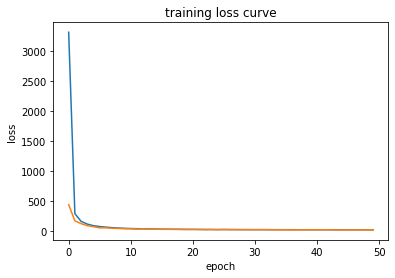

In [ ]:
# loss trend chart
plt.plot(history.epoch, history.history['loss'], history.epoch, history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('training loss curve')

plt.show()

In [ ]:
!pwd

/content/gdrive/My Drive/DLCVMarathonFinalProject


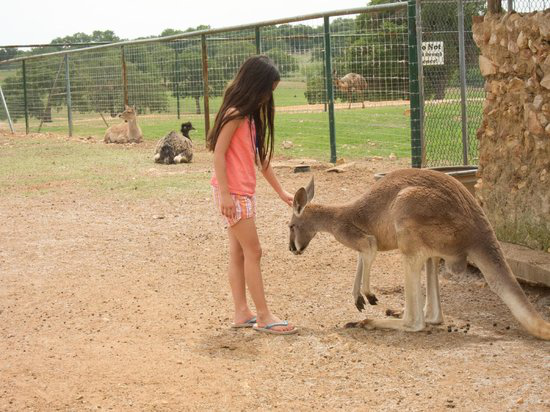

In [ ]:
from PIL import Image
image = Image.open('Data/kangaroo/images/00012.jpg')
image

In [ ]:
from yolo import YOLO

# 注意：added by chi hsu 20200821
# ImageFont有cannot open resource錯誤的話，是因為沒有指定的font file，需要手動自行到yolo.py中的detect_image修改
yolo_model = YOLO(model_path= log_dir + 'trained_weights_stage_1.h5', classes_path=classes_path)
r_image = yolo_model.detect_image(image)

logs/003/trained_weights_stage_1.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.86 (274, 180) (550, 324)
1.8729801279996536


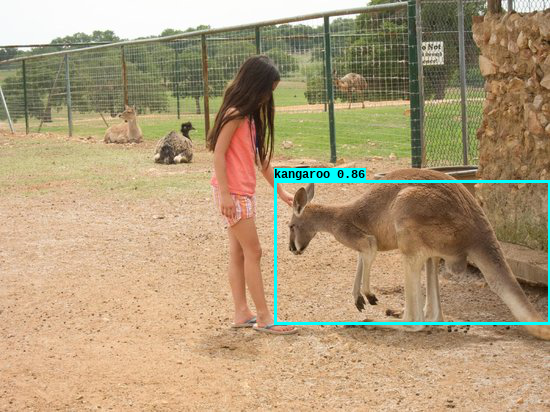

In [ ]:
r_image

In [ ]:
image2 = Image.open('Data/kangaroo/images/00043.jpg')

r_image2 = yolo_model.detect_image(image2)

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (12, 0) (501, 397)
0.0860568709999825


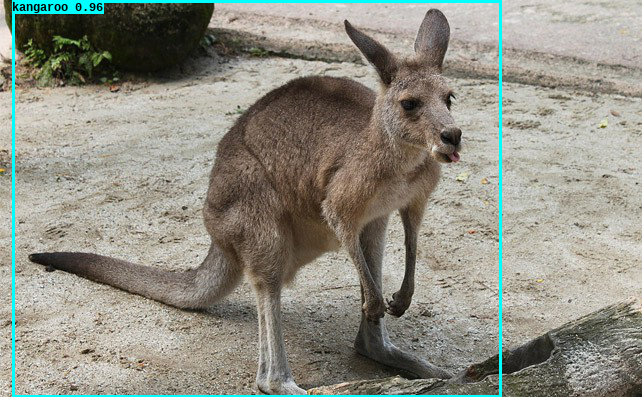

In [ ]:
r_image2

In [ ]:
image3 = Image.open('Data/kangaroo/images/00080.jpg')

r_image3 = yolo_model.detect_image(image3)

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.64 (187, 0) (668, 663)
0.08821507699985887


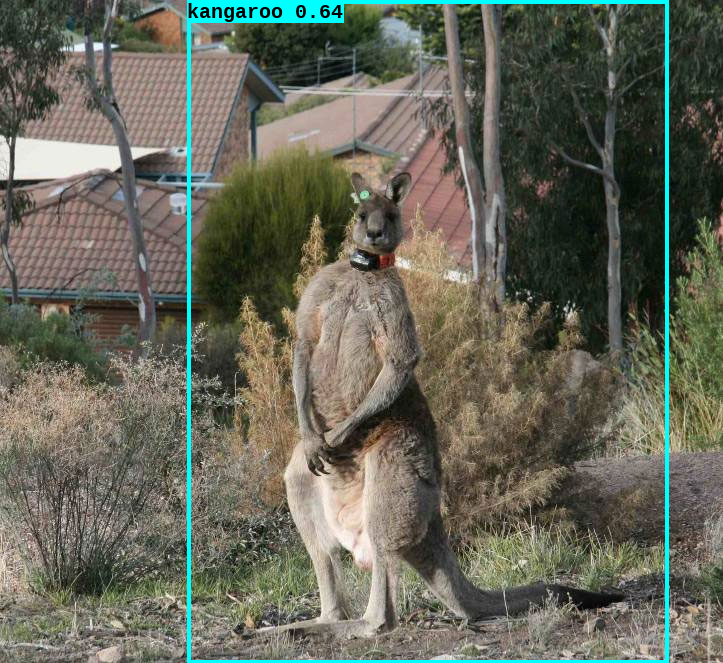

In [ ]:
r_image3

In [ ]:
image4 = Image.open('Data/raccoon_dataset/images/raccoon-11.jpg')

r_image4 = yolo_model.detect_image(image4)

(416, 416, 3)
Found 1 boxes for img
raccoon 0.78 (0, 0) (445, 432)
0.08474128899979405


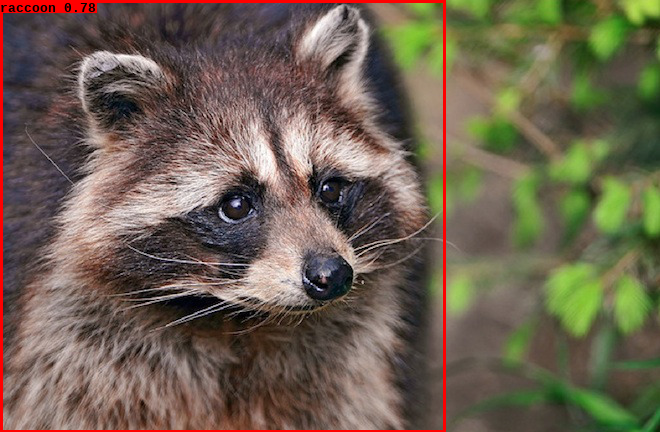

In [ ]:
r_image4

In [ ]:
image5 = Image.open('Data/raccoon_dataset/images/raccoon-25.jpg')

r_image5 = yolo_model.detect_image(image5)

(416, 416, 3)
Found 1 boxes for img
raccoon 0.41 (0, 168) (409, 554)
0.09195883900019908


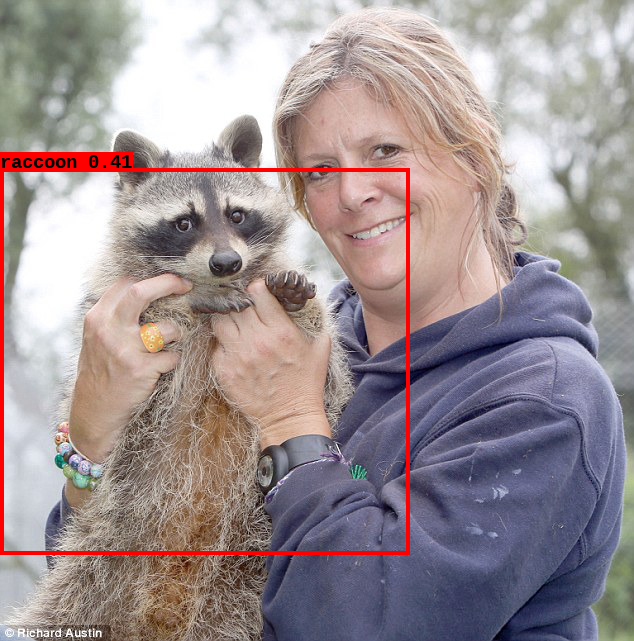

In [ ]:
r_image5

# 偵測影片

In [ ]:
import time
import cv2

def detect_video(yolo, video_path, output_path=""):
    cap=cv2.VideoCapture(video_path)
    if not cap.isOpened():
      raise IOError("open webcam or video failed!")
       
    FourCC=cv2.VideoWriter_fourcc(*'mp4v')
    fps=cap.get(cv2.CAP_PROP_FPS)
    size=(int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    
    if output_path != "":
      isOutput=True
    else:
      isOutput=False
    
    if isOutput:
      out=cv2.VideoWriter(output_path, FourCC, fps, size)
        
    while(cap.isOpened()):
      ret,frame=cap.read()
                
      if ret==True: 
        # PIL Image transfer
        image=Image.fromarray(np.uint8(frame))                
        image=yolo.detect_image(image)        
        result=np.array(image)        
        
        if isOutput:
          out.write(result)
        
      else:
        break
    
    cap.release()
    out.release()
    
    return

In [ ]:
# raccoon.mp4
detect_video(yolo_model, video_path='Data/video/raccoon.mp4', output_path="Data/video/raccoon_out.mp4")
print('detection completed!')

串流輸出內容已截斷至最後 5000 行。
0.05144556300001568
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (469, 0) (985, 720)
0.05172012499951961
(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (440, 0) (1009, 720)
0.0529514529998778
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (437, 3) (1011, 720)
0.05123423099939828
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (454, 22) (1005, 720)
0.05476568700032658
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (399, 0) (1072, 720)
0.05697904899989226
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (467, 0) (1011, 720)
0.05167456400067749
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (434, 0) (1057, 720)
0.051893425000343996
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (388, 0) (1095, 720)
0.051418846000160556
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (431, 0) (1053, 720)
0.0555983809999816
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (415, 0) (1074, 720)
0.05286220899961336
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (445, 0) (